<a href="https://colab.research.google.com/github/hozongsien/PyTorchTutorial/blob/master/PyTorchTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression
[tutorial reference](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Linear Regression in Numpy

Generating Toy Data

In [0]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
n = 100

a = 2
b = 1
epsilon = 0.1 * np.random.randn(n, 1)

x = np.random.rand(n, 1)
y = a * x + b + epsilon

In [0]:
idx = np.arange(100)
np.random.shuffle(idx)

train_idx = idx[:80]
val_idx = idx[80:]

x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

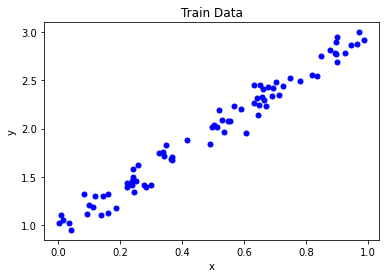

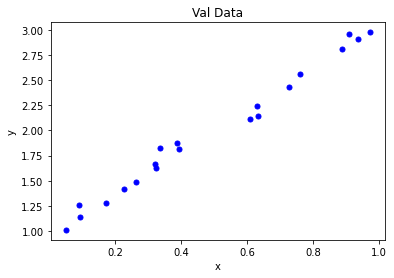

In [195]:
def plotData(x_data, y_data, title):
  plt.plot(x_data, y_data, 'ob', ms=5)
  plt.title(title)
  plt.ylabel('y')
  plt.xlabel('x')
  plt.show()

plotData(x_train, y_train, 'Train Data')
plotData(x_val, y_val, 'Val Data')

Training

In [196]:
# Hyperparams
lr = 0.1
NUM_EPOCHS = 1000

# Initialise random weights
a_p = np.random.randn(1)
b_p = np.random.randn(1)

# BGD
for epoch in range(NUM_EPOCHS):
  # compute output
  y_hat = y = a_p * x_train + b_p 
  
  # compute loss
  error = y_train - y_hat
  loss = (error ** 2).mean() # MSE

  # compute gradient
  a_grad = -2 * (x_train * error).mean()
  b_grad = -2 * error.mean() 

  # update params
  a_p = a_p - lr * a_grad
  b_p = b_p - lr * b_grad

print('ground truth:')
print('a: {:.3f}; b: {:.3f}'.format(a, b))
print('predicted:')
print('a: {:.3f}; b: {:.3f}'.format(a_p[0], b_p[0]))

ground truth:
a: 2.000; b: 1.000
predicted:
a: 2.036; b: 0.968


## Linear Regression in PyTorch

In [0]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [0]:
torch.manual_seed(RANDOM_SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparams
lr = 0.1
NUM_EPOCHS = 1000
BATCH_SIZE = 16
VAL_BATCH_SIZE = 20

Linear regression model

In [0]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)
        
    def forward(self, x):
        return self.linear(x)

Data preparation

In [204]:
# train set
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = TensorDataset(x_train_tensor, 
                           y_train_tensor) # list of observations as tuples (x, y)
train_loader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True) # split into mini batches

# validation set
x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

val_data = TensorDataset(x_val_tensor, 
                         y_val_tensor)
val_loader = DataLoader(dataset=val_data, 
                        batch_size=VAL_BATCH_SIZE, 
                        shuffle=False)

# model
model = LinearRegression().to(device)
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[-0.3693]], device='cuda:0')), ('linear.bias', tensor([0.2237], device='cuda:0'))])


Training

In [0]:
def make_train_step(model, criterion, optimizer):
  def train_step(x, y):
    model.train()

    # compute output
    y_hat = model(x)

    # compute loss
    loss = criterion(y, y_hat)

    # compute gradient 
    loss.backward()

    # update params
    optimizer.step()

    # reset gradients
    optimizer.zero_grad()

    return loss.item()

  return train_step


def make_val_step(model, criterion):
  def val_step(x, y):
    model.eval()

    y_hat = model(x)
    loss = criterion(y, y_hat)
    return loss.item()

  return val_step

In [232]:
# Define loss
criterion = nn.MSELoss(reduction='mean')

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

# Mini-BGD
train_step = make_train_step(model, criterion, optimizer)
val_step = make_val_step(model, criterion)

losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
  for i, (x_train_mini, y_train_mini) in enumerate(train_loader):
    x_train_mini = x_train_mini.to(device)
    y_train_mini = y_train_mini.to(device)

    loss = train_step(x_train_mini, y_train_mini)
    losses.append(loss)

    with torch.no_grad():
      for j, (x_val_mini, y_val_mini) in enumerate(val_loader):
        x_val_mini = x_val_mini.to(device)
        y_val_mini = y_val_mini.to(device)

        val_loss = val_step(x_val_mini, y_val_mini)
        val_losses.append(val_loss)
  
  if epoch % 100 == 99:
    print('epoch: {} loss: {:.3f} val loss: {:.3f}'.
          format(epoch + 1, 
                 losses[(epoch+1) * (i+1) - 1], 
                 val_losses[(epoch+1) * (j+1) - 1]))

print('Finished Training')
print()

print('ground truth:')
print('a: {:.3f}; b: {:.3f}'.format(a, b))
print('predicted:')
print('a: {:.3f}; b: {:.3f}'.format(model.state_dict()['linear.weight'].item(),
                                    model.state_dict()['linear.bias'].item()))

epoch: 100 loss: 0.016 val loss: 0.006
epoch: 200 loss: 0.007 val loss: 0.006
epoch: 300 loss: 0.007 val loss: 0.006
epoch: 400 loss: 0.013 val loss: 0.006
epoch: 500 loss: 0.008 val loss: 0.006
epoch: 600 loss: 0.011 val loss: 0.006
epoch: 700 loss: 0.007 val loss: 0.006
epoch: 800 loss: 0.006 val loss: 0.006
epoch: 900 loss: 0.011 val loss: 0.006
epoch: 1000 loss: 0.007 val loss: 0.006
Finished Training

ground truth:
a: 2.000; b: 1.000
predicted:
a: 2.037; b: 0.970
